It's time to fine-tune our WaveNet using the ResNet

In [1]:
colab = False

import torch
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import nn
from torch.nn import functional as F
from torchsummary import summary
import matplotlib.pyplot as plt

import os
import math
import time
import sys
import shutil
import copy
import IPython.display as ipd

import numpy as np

if colab:
  !pip install -q livelossplot
  !pip install -q kaldi_io
  !pip install -q kaldiio
  os.environ['KALDI_ROOT'] = '/content/drive/My Drive/Stage-Imaging/Signal-denoising-in-the-wild'
else:
    os.environ['KALDI_ROOT'] = '/opt/kaldi/'

import kaldi_io
import kaldiio
#from livelossplot import PlotLosses
import librosa
from tqdm.notebook import tqdm

In [2]:
from DWaveNet import DWaveNet
from datasets import SequenceDataset
from utils import ScheduledOptim, change_path_scp, EnergyConservingLoss, plot_modelPerformance, l1_mse_loss, splitAudio

In [3]:
train_dataset = SequenceDataset('../data/train/trainLAB.scp', '../data/utt2spk.scp', min_length = 16000, colab = False)
test_dataset = SequenceDataset('../data/test/testLAB.scp', '../data/utt2spk.scp', min_length = 16000, colab = False)
train_data = DataLoader(train_dataset, batch_size = 8, shuffle=True)
test_data = DataLoader(test_dataset, batch_size = 8, shuffle=True)

Totally 7344 samples with at most 247 samples for one class
Totally 816 samples with at most 247 samples for one class


In [4]:
net = DWaveNet(in_channels = 1, target_field_length = None, num_layers = 30,
                 num_stacks = 3, residual_channels = 128,
                 gate_channels = 128, skip_out_channels = 128,
                 last_channels=(1024, 256))

In [5]:
if colab:
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  device
else:  
  os.environ["CUDA_VISIBLE_DEVICES"] = '0, 1'
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  device

In [6]:
#optim = torch.optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr = 0.001, eps = 1e-08, weight_decay=0.0)
optim = ScheduledOptim( # Transformer optimizer
        torch.optim.Adam(
            filter(lambda p: p.requires_grad,
                   net.parameters()),
            betas = (0.9, 0.98),
             eps = 1e-09,
              weight_decay = 1e-4,
               amsgrad = True),
                n_warmup_steps = 8000)

start_epoch = 1
best = {}
best['train'] = 100000
best['validation'] = 100000
best_epoch = -1
history = None

pretrain_model_pth = "../log/denoising/wavenet3/model_best.pth.tar"

# if pretrain_model_pth is not None:
#     if os.path.isfile(pretrain_model_pth):
#         print('loading pre-trained model from %s' % pretrain_model_pth)
#         model_dict = net.state_dict()
#         checkpoint = torch.load(pretrain_model_pth, map_location = lambda storage, loc: storage) # load for cpu
#         net.load_state_dict({k.replace('module.',''):v for k,v in checkpoint['state_dict'].items()})
#     else:
#         print("===> no checkpoint found at '{}'".format(pretrain_model_pth))
        
if pretrain_model_pth is not None:
    if os.path.isfile(pretrain_model_pth):
        print('loading pre-trained model from %s' % pretrain_model_pth)
        model_dict = net.state_dict()
        checkpoint = torch.load(pretrain_model_pth, map_location = lambda storage, loc: storage) # load for cpu
        
        #start_epoch = checkpoint['epoch'] + 1
        #best_epoch = checkpoint['epoch']
        #best = checkpoint['best_losses']
        #history = checkpoint['history']
        #print(checkpoint['state_dict'])
        #model.load_state_dict(checkpoint['state_dict'])
        
        net.load_state_dict({k.replace('module.',''):v for k,v in checkpoint['state_dict'].items()})
        
        #optim.load_state_dict(checkpoint['optimizer'])
    else:
        print("===> no checkpoint found at '{}'".format(pretrain_model_pth))
#         #exit()

loading pre-trained model from ../log/denoising/wavenet3/model_best.pth.tar


In [7]:
import glob
from SpeakerNet import SpeakerNet
from DatasetLoader import DatasetLoader

In [8]:
# params
if colab:
    base_path = '/content/drive/My Drive/Stage-Imaging/'
else:
    base_path = '/opt/kaldi/egs/'
eval = True
model = 'ResNetSE34L'
trainfunc = 'angleproto'
save_path = '/content/drive/My Drive/Stage-Imaging/'
max_frames = 300
batch_size = 200
max_seg_per_spk = 100
nDataLoaderThread = 5
max_epoch = 500
optimizer = 'adam'
hard_prob = .5
hard_rank = 10
margin = 1
scale = 15
nSpeakers = 5994
if colab:
    test_path = '/content/drive/My Drive/Datasets/VoxCeleb1_test/wav/'
else:
    test_path = '/export/corpora/VoxCeleb1_test/wav/'
initial_model = 'baseline_lite_ap.model'
encoder_type = 'SAP'
nOut = 512
lr = 0.001


# defaults
lr_decay = .95
test_interval = 10

In [9]:
s = SpeakerNet(model = model, trainfunc = trainfunc, max_frames = max_frames, batch_size = batch_size, max_seg_per_spk = max_seg_per_spk, nDataLoaderThread = nDataLoaderThread, encoder_type = encoder_type, nOut = nOut,
               test_interval = test_interval, max_epoch = max_epoch, optimizer = optimizer, lr = lr, lr_decay = lr_decay, hard_prob = hard_prob, hard_rank = hard_rank, margin = margin, scale = scale,
               nSpeakers = nSpeakers)

it = 1
prevloss = float("inf")
sumloss = 0

Embedding size is 512, encoder SAP.
Initialised AngleProto


In [10]:
## Load model weights
modelfiles = glob.glob('%s/model0*.model'%save_path)
modelfiles.sort()

if len(modelfiles) >= 1:
    s.loadParameters(modelfiles[-1]);
    print("Model %s loaded from previous state!"%modelfiles[-1]);
    it = int(os.path.splitext(os.path.basename(modelfiles[-1]))[0][5:]) + 1
elif(initial_model != ""):
    s.loadParameters(initial_model);
    print("Model %s loaded!"%initial_model);

for ii in range(0, it-1):
    if ii % test_interval == 0:
        clr = s.updateLearningRate(lr_decay)

Model baseline_lite_ap.model loaded!


In [11]:
def train_model(start_epoch, best, best_epoch, loaders, model, classifier, optimizer, use_cuda, history = None,
                verbose = True, log_dir = '../log/denoising/wavenet5/', save = True):
    
  idx = np.random.randint(len(test_data.dataset))
  clean, dirty, _ = test_dataset[idx]

  if use_cuda:
    model = nn.DataParallel(model)
    model = model.to(device)

  if history is None:
    logs = {}
    logs['train'] = []
    logs['validation'] = []
  else:
    logs = copy.deepcopy(history)

  for epoch in range(start_epoch, start_epoch + 50):  
    epoch_losses = {}
    
    for phase in ['train', 'validation']:
      
      if phase == 'train':
        model.train()
        classifier.eval()
      else:
        model.eval()
        classifier.eval()
        
      if phase == 'train':
        print('Epoch %d' % epoch)
        start = time.time()
      
      running_loss = 0.0
      
      for batch_idx, (target, data, _) in enumerate(tqdm(loaders[phase])):

        if use_cuda:
          data, target = data.to(device), target.to(device)
        denoised = model(data)
            
        #print(output.size())
        #with torch.no_grad():
        output = F.normalize(classifier.forward(denoised.squeeze(1)), p=2, dim = 1)
        target = F.normalize(classifier.forward(target.squeeze(1)), p=2, dim = 1)
            
        loss = torch.nn.MSELoss(reduction = 'sum')(output, target)

        if phase == 'train':
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          lr = optimizer.update_learning_rate()
          #lr = 0.001
        running_loss += loss.detach() #* data.size(0))
        #print(running_loss)

        del data, target, output, loss, denoised

      epoch_loss =  running_loss / len(loaders[phase].dataset)
      epoch_losses[phase] = copy.deepcopy(epoch_loss.item())
      if phase == 'train':
        if verbose:
          print('Train Epoch:{}\tlr:{:.5f}\tLoss:{:.8f}\tTime:{:.2f} m'.format(epoch, lr, epoch_loss, (time.time()-start)/60))
      else:
        if verbose:
          print('Validation Loss:{:.8f}'.format(epoch_loss))
      logs[phase].extend([epoch_loss.item()])
    if save:
      if ((epoch_losses['train'] < best['train'])): #and (epoch_losses['validation'] < best['validation'])):
        best = epoch_losses
        torch.save({
            'epoch': epoch,
            'state_dict': model.state_dict(),
            'best_losses': best,
            'optimizer' : optimizer.state_dict(),
            'history': logs
        }, log_dir + str(epoch) + "_" + str(sum(epoch_losses.values())) + ".h5")
        print("===> save to checkpoint at {}\n".format(log_dir + 'model_best.pth.tar'))
        shutil.copyfile(log_dir + str(epoch) + "_" + str(sum(epoch_losses.values())) +
                ".h5", log_dir + 'model_best.pth.tar')
        best_epoch = epoch
      elif epoch - best_epoch > 5:
        print('===> increase delta optimizer')
        optimizer.increase_delta()
        best_epoch = epoch

    plot_modelPerformance(logs, clean, dirty, model)

In [12]:
loaders = {'train' : train_data, 'validation' : test_data}

Epoch 1



Train Epoch:1	lr:0.00016	Loss:0.58012533	Time:1.37 m



Validation Loss:0.54901063
===> save to checkpoint at ../log/fine_tuning/wavenet3/model_best.pth.tar



Epoch 2



Train Epoch:2	lr:0.00032	Loss:0.57991081	Time:1.32 m



Validation Loss:0.52994221
===> save to checkpoint at ../log/fine_tuning/wavenet3/model_best.pth.tar



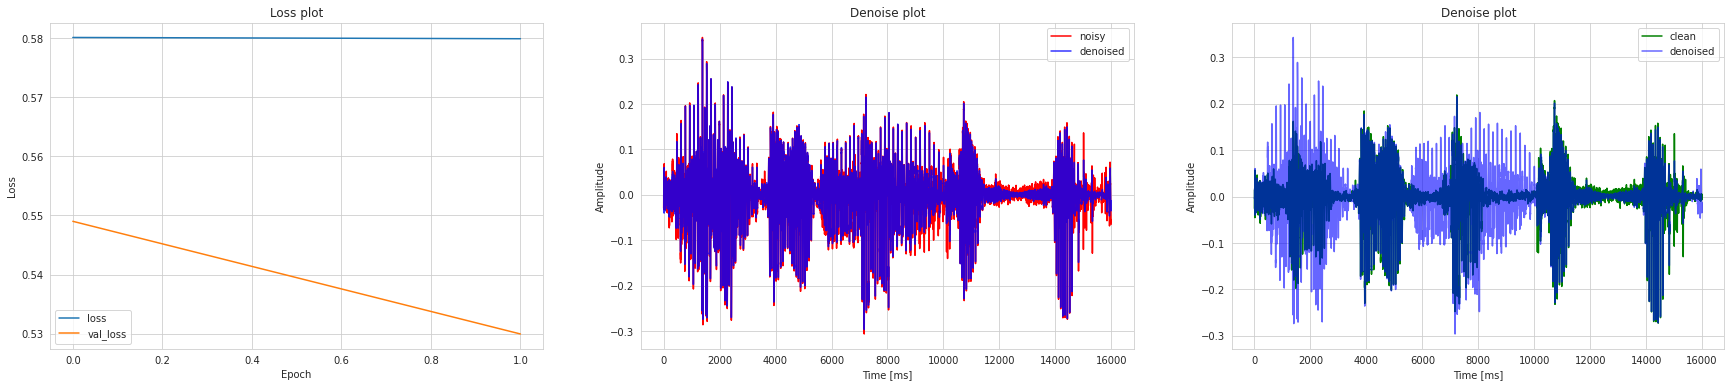

Epoch 3



Train Epoch:3	lr:0.00048	Loss:0.57616329	Time:1.32 m



Validation Loss:0.55486447
===> save to checkpoint at ../log/fine_tuning/wavenet3/model_best.pth.tar



Epoch 4



Train Epoch:4	lr:0.00064	Loss:0.58146328	Time:1.33 m



Validation Loss:0.54907304


Epoch 5



Train Epoch:5	lr:0.00080	Loss:0.57814652	Time:1.32 m



Validation Loss:0.56469917


Epoch 6



Train Epoch:6	lr:0.00096	Loss:0.57871091	Time:1.32 m



Validation Loss:0.53943115


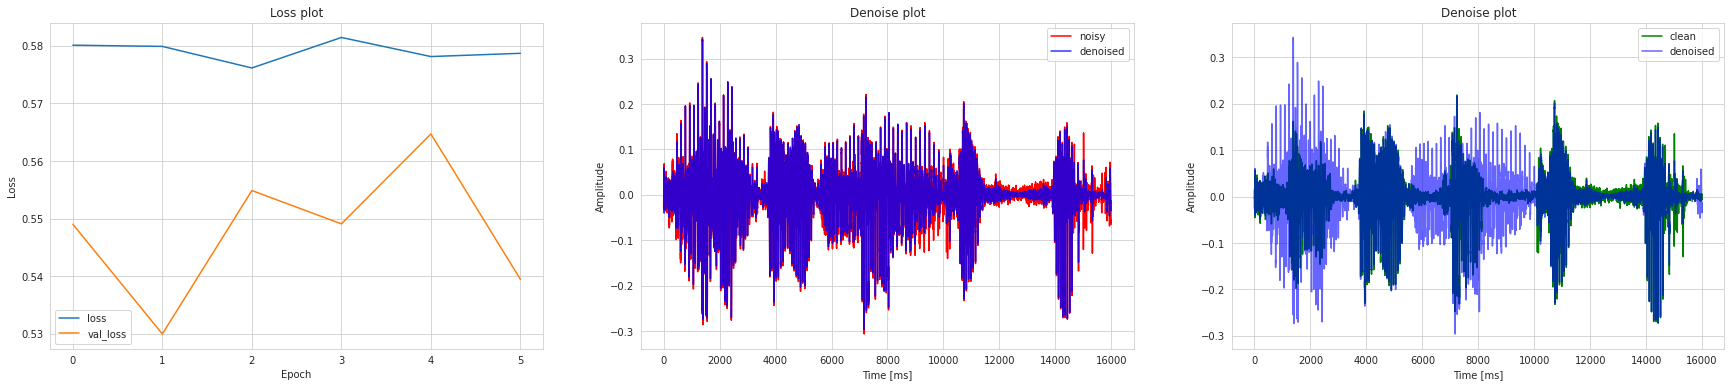

Epoch 7



Train Epoch:7	lr:0.00112	Loss:0.58109099	Time:1.32 m



Validation Loss:0.53360736


Epoch 8



Train Epoch:8	lr:0.00128	Loss:0.58374685	Time:1.32 m



Validation Loss:0.55052519


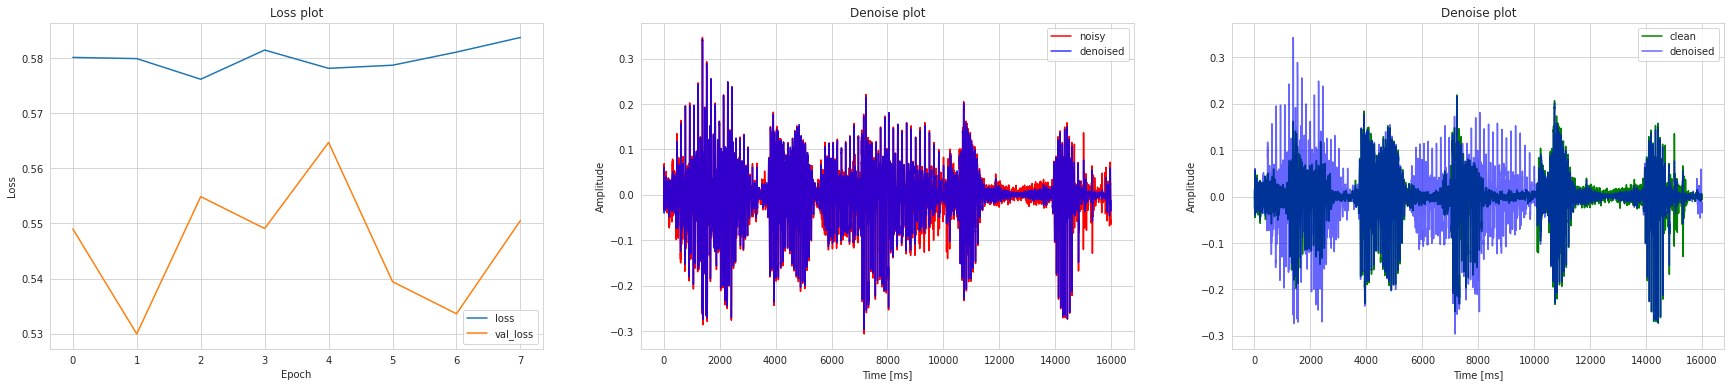

Epoch 9



Train Epoch:9	lr:0.00138	Loss:0.58033204	Time:1.32 m



Validation Loss:0.55518448
===> increase delta optimizer


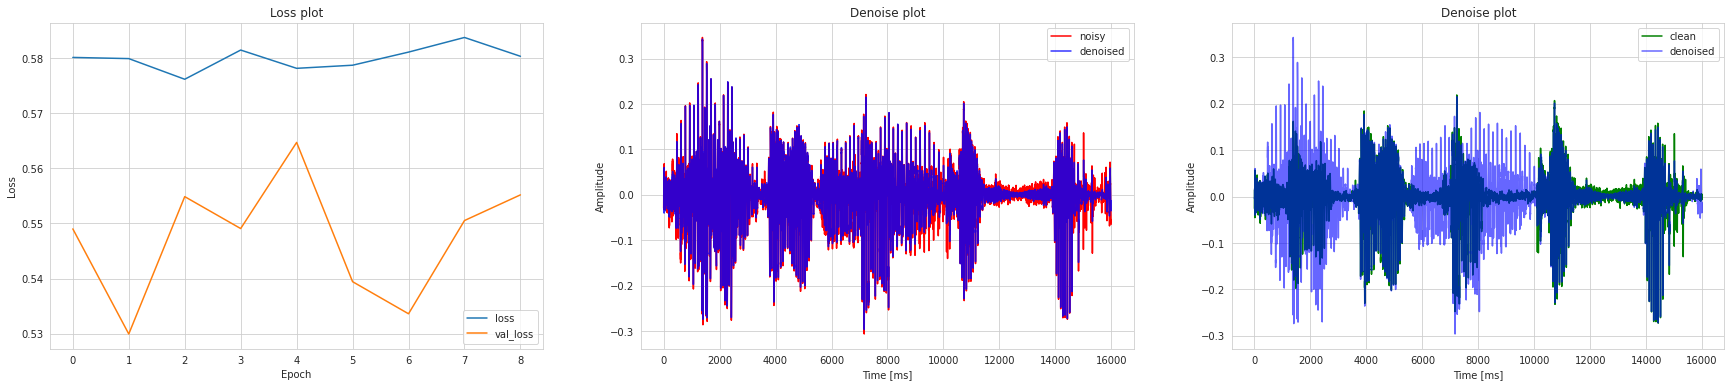

Epoch 10



Train Epoch:10	lr:0.00124	Loss:0.57845199	Time:1.32 m



Validation Loss:0.55228734


Epoch 11



Train Epoch:11	lr:0.00114	Loss:0.58097452	Time:1.33 m



Validation Loss:0.55733764


Epoch 12



Train Epoch:12	lr:0.00107	Loss:0.57923585	Time:1.32 m



Validation Loss:0.54526389


Epoch 13



Train Epoch:13	lr:0.00100	Loss:0.57913804	Time:1.32 m



Validation Loss:0.57263958


Epoch 14



Train Epoch:14	lr:0.00095	Loss:0.58140147	Time:1.32 m



Validation Loss:0.54842126


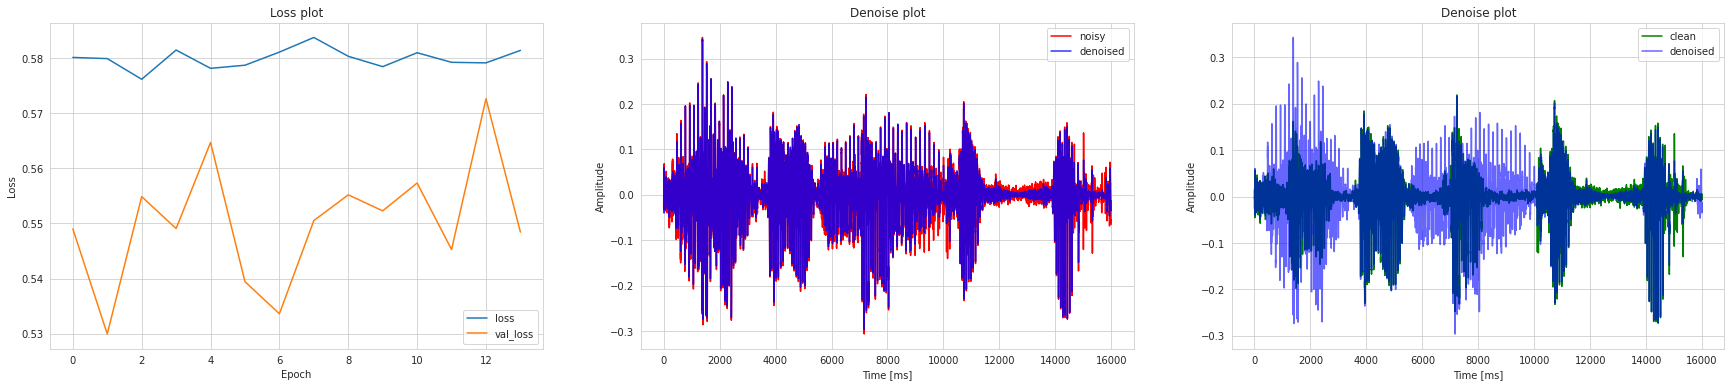

Epoch 15



Train Epoch:15	lr:0.00090	Loss:0.57644135	Time:1.31 m



Validation Loss:0.55143529
===> increase delta optimizer


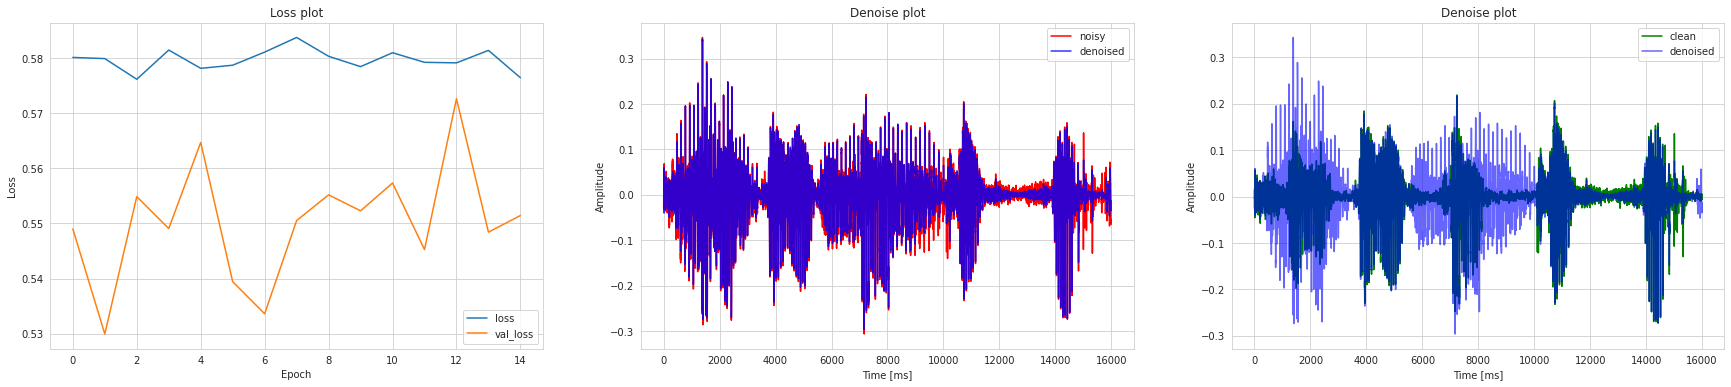

Epoch 16



Train Epoch:16	lr:0.00083	Loss:0.58156127	Time:1.31 m



Validation Loss:0.54651880


Epoch 17



Train Epoch:17	lr:0.00077	Loss:0.57368404	Time:1.31 m



Validation Loss:0.54955280
===> save to checkpoint at ../log/fine_tuning/wavenet3/model_best.pth.tar



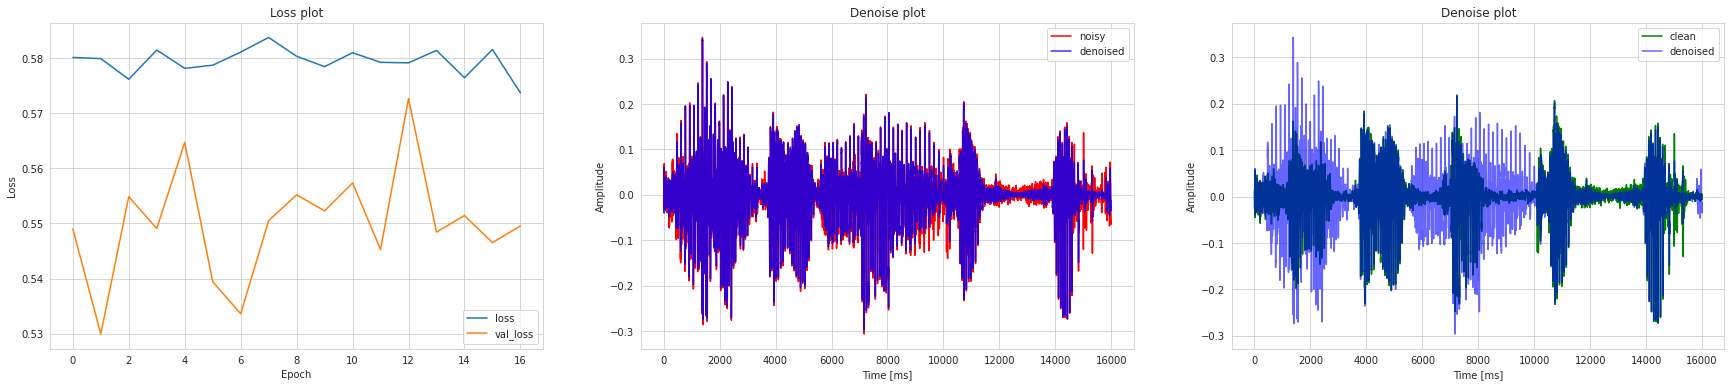

Epoch 18



Train Epoch:18	lr:0.00072	Loss:0.57883048	Time:1.31 m



Validation Loss:0.54357922


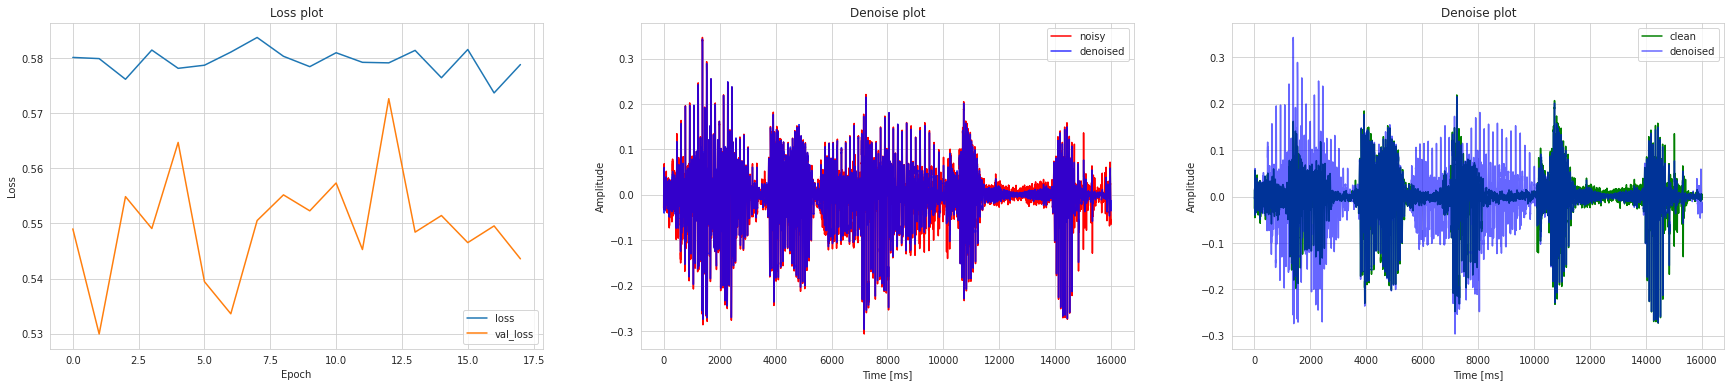

Epoch 19



Train Epoch:19	lr:0.00068	Loss:0.58254260	Time:1.31 m



Validation Loss:0.55442327


Epoch 20



Train Epoch:20	lr:0.00064	Loss:0.57447070	Time:1.32 m



Validation Loss:0.55263567


Epoch 21



Train Epoch:21	lr:0.00062	Loss:0.58783484	Time:1.32 m



Validation Loss:0.55194682


Epoch 22



Train Epoch:22	lr:0.00059	Loss:0.58179349	Time:1.31 m



Validation Loss:0.54322541


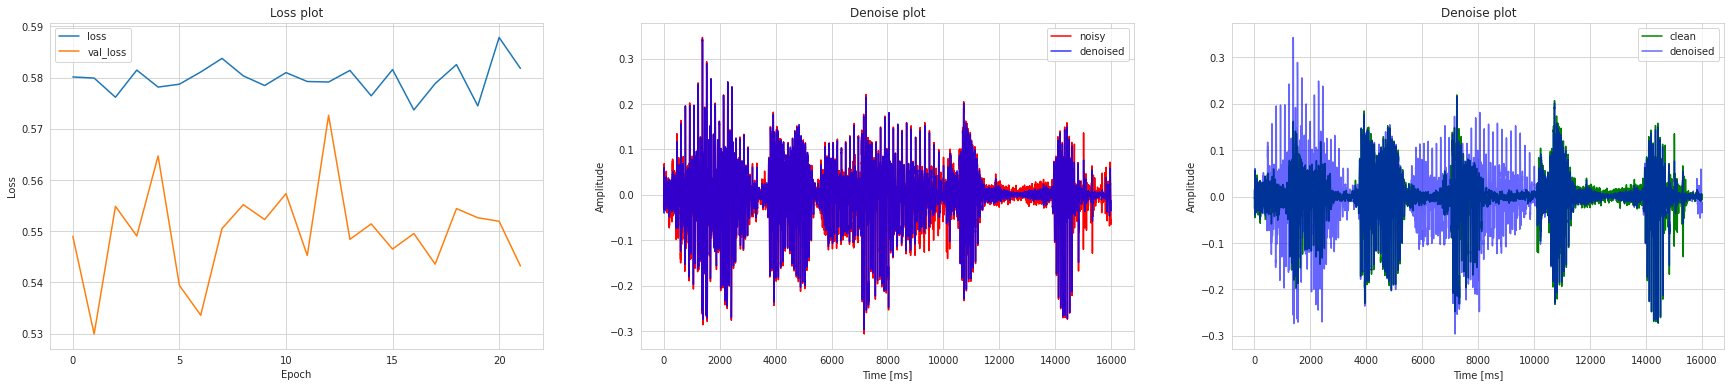

Epoch 23



Train Epoch:23	lr:0.00057	Loss:0.58101082	Time:1.33 m



Validation Loss:0.56143379
===> increase delta optimizer


Epoch 24



Train Epoch:24	lr:0.00053	Loss:0.57979459	Time:1.32 m



Validation Loss:0.55522287


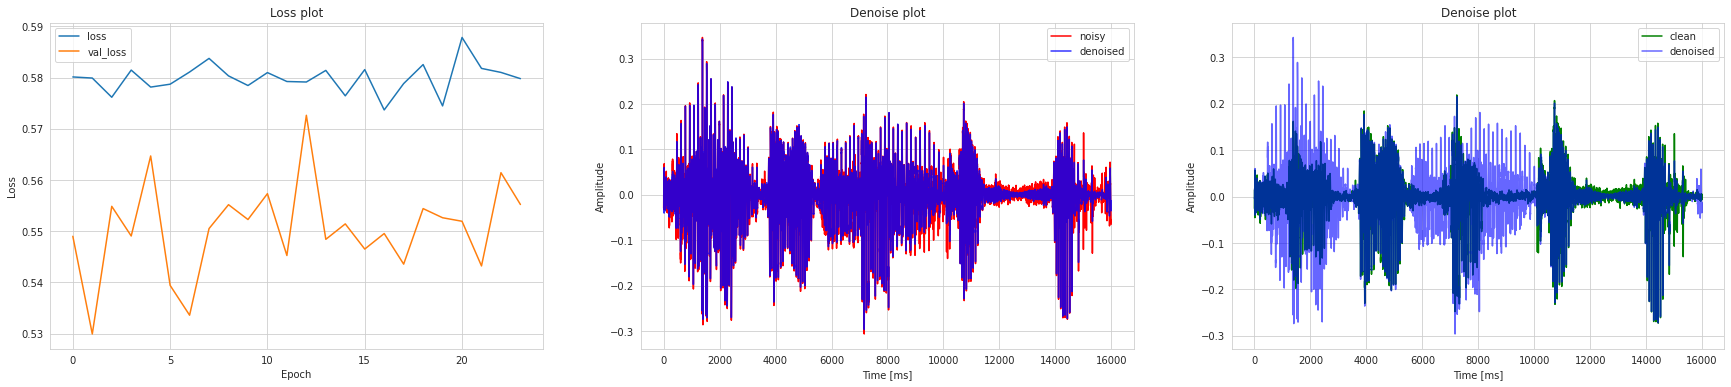

Epoch 25



Train Epoch:25	lr:0.00050	Loss:0.58187050	Time:1.33 m



Validation Loss:0.55127597


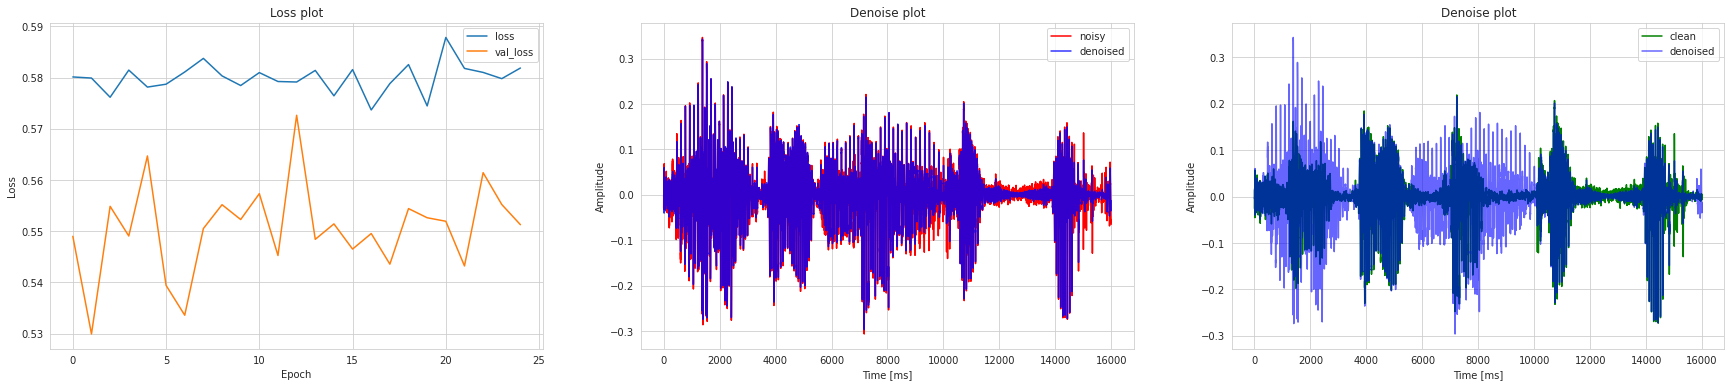

Epoch 26



Train Epoch:26	lr:0.00047	Loss:0.57851088	Time:1.32 m



Validation Loss:0.54809511


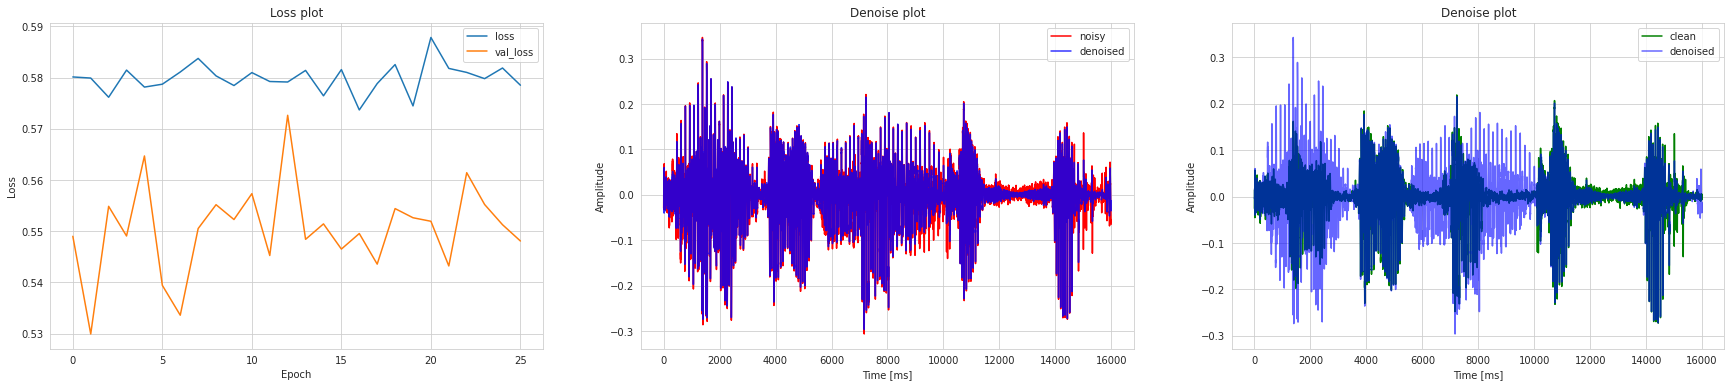

Epoch 27



Train Epoch:27	lr:0.00045	Loss:0.57551658	Time:1.31 m



Validation Loss:0.54033905


Epoch 28



Train Epoch:28	lr:0.00043	Loss:0.58327615	Time:1.32 m



Validation Loss:0.54511786


Epoch 29



Train Epoch:29	lr:0.00041	Loss:0.57952887	Time:1.32 m



Validation Loss:0.53670573
===> increase delta optimizer


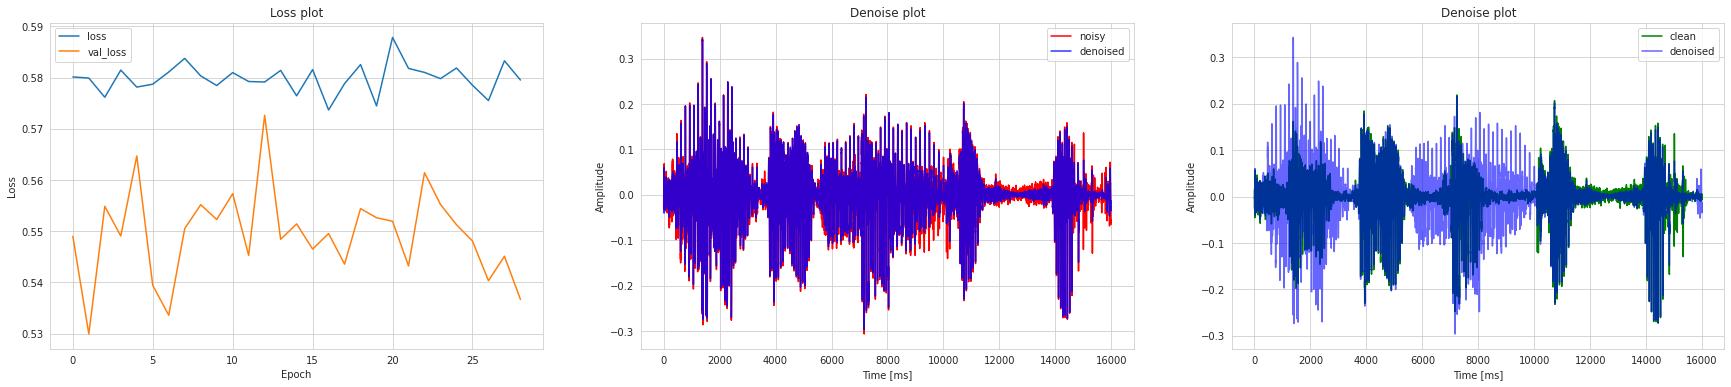

Epoch 30



Train Epoch:30	lr:0.00038	Loss:0.57721901	Time:1.31 m



Validation Loss:0.54888660


Epoch 31



Train Epoch:31	lr:0.00036	Loss:0.58266109	Time:1.31 m



Validation Loss:0.55700231


Epoch 32



Train Epoch:32	lr:0.00034	Loss:0.57757831	Time:1.31 m



Validation Loss:0.54834431


Epoch 33



Train Epoch:33	lr:0.00032	Loss:0.57780892	Time:1.32 m



Validation Loss:0.56159216


Epoch 34



Train Epoch:34	lr:0.00031	Loss:0.57976347	Time:1.32 m



Validation Loss:0.55308694


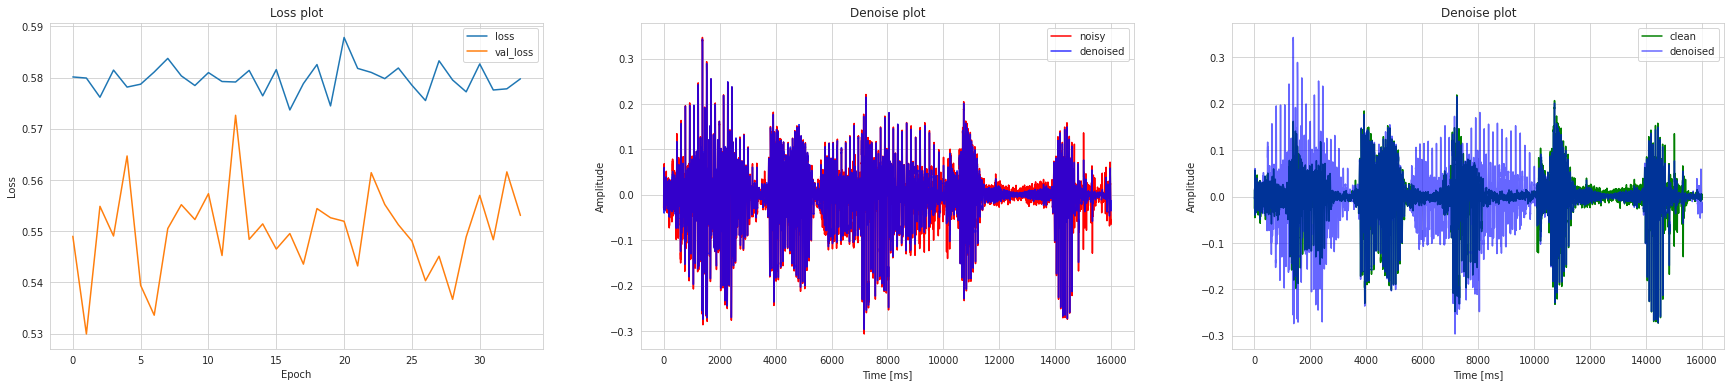

Epoch 35



Train Epoch:35	lr:0.00029	Loss:0.57760876	Time:1.31 m



Validation Loss:0.54857689
===> increase delta optimizer


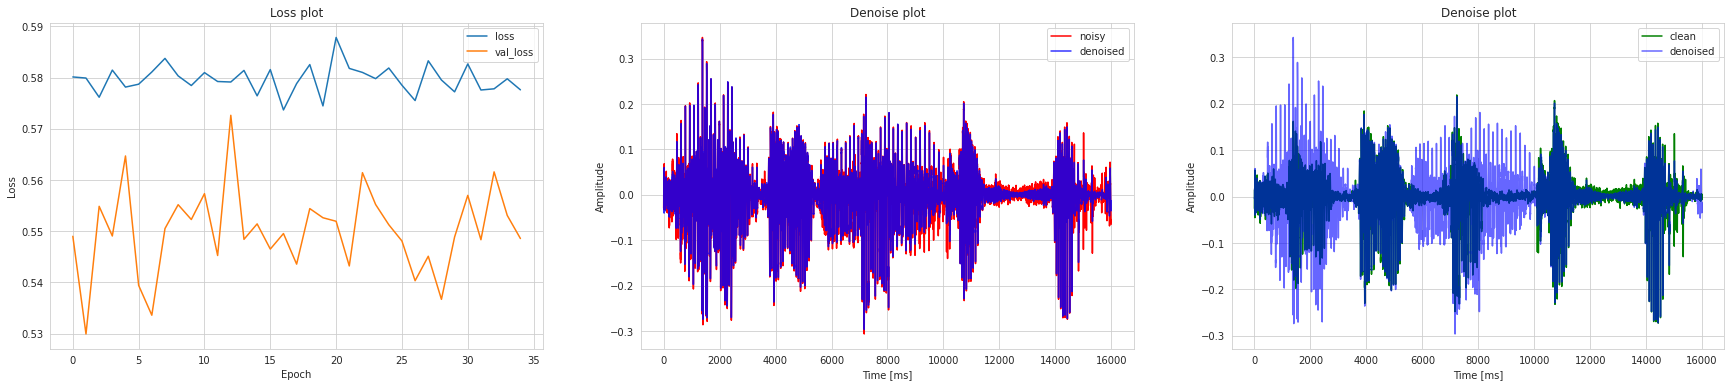

Epoch 36



Train Epoch:36	lr:0.00027	Loss:0.57644862	Time:1.31 m



Validation Loss:0.55609643


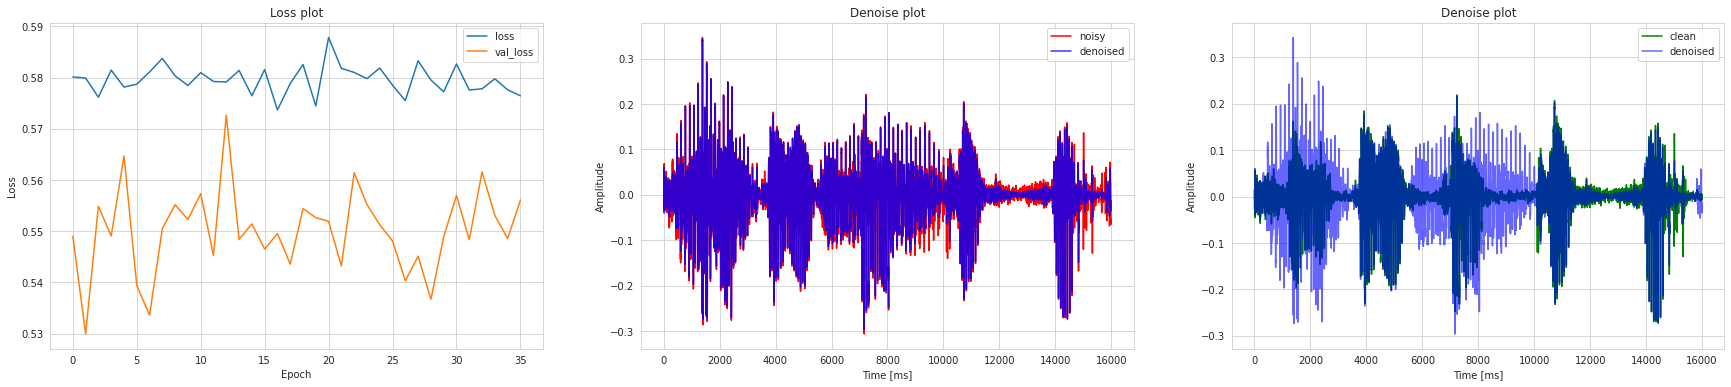

Epoch 37



Train Epoch:37	lr:0.00026	Loss:0.58486903	Time:1.31 m



Validation Loss:0.56396425


Epoch 38



Train Epoch:38	lr:0.00024	Loss:0.58109832	Time:1.32 m



Validation Loss:0.54880011


Epoch 39



Train Epoch:39	lr:0.00023	Loss:0.58156610	Time:1.33 m



Validation Loss:0.53503323


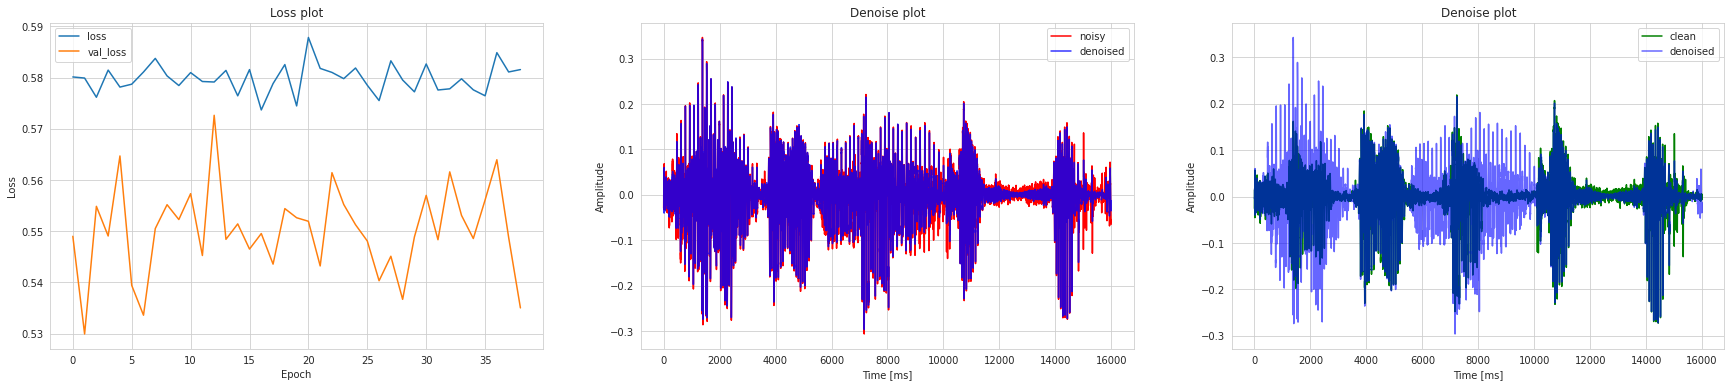

Epoch 40



Train Epoch:40	lr:0.00022	Loss:0.58097476	Time:1.32 m



Validation Loss:0.54961622


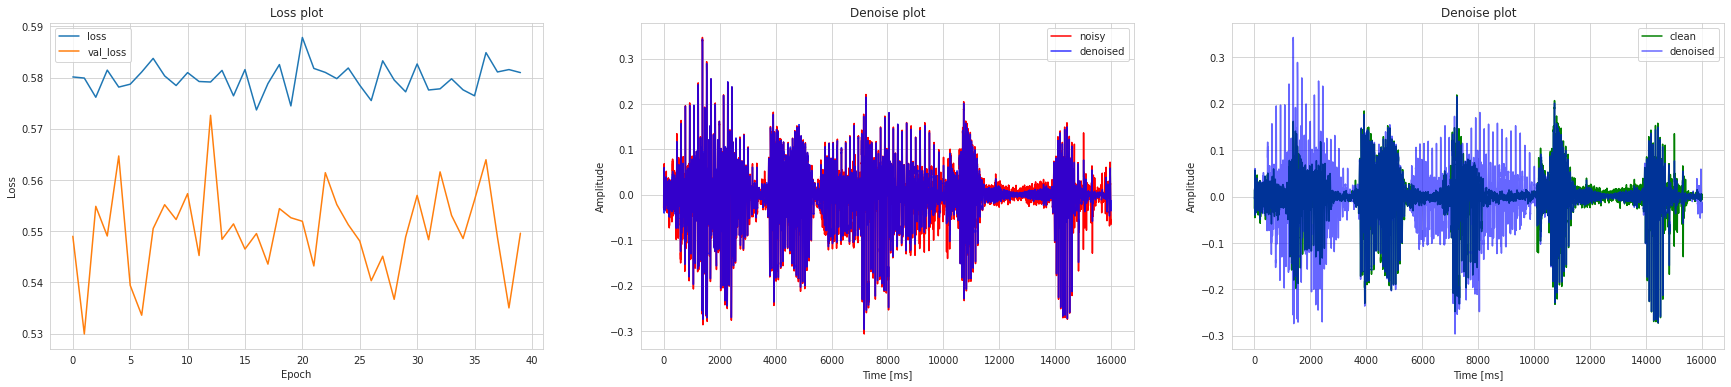

Epoch 41



Train Epoch:41	lr:0.00021	Loss:0.58081311	Time:1.31 m



Validation Loss:0.55390328
===> increase delta optimizer


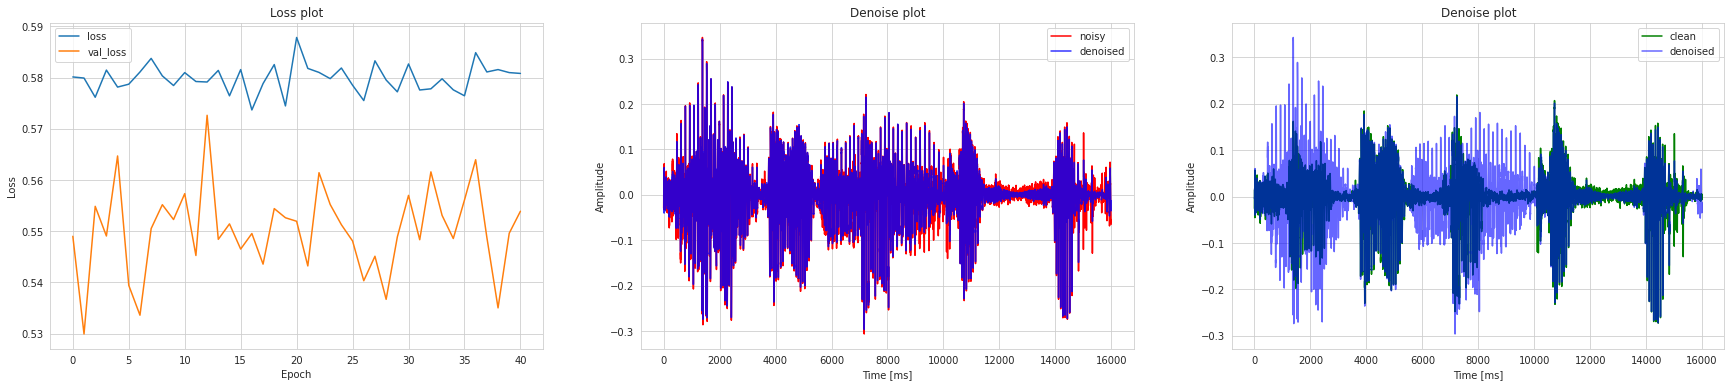

Epoch 42



Train Epoch:42	lr:0.00019	Loss:0.58027768	Time:1.31 m



Validation Loss:0.54392606


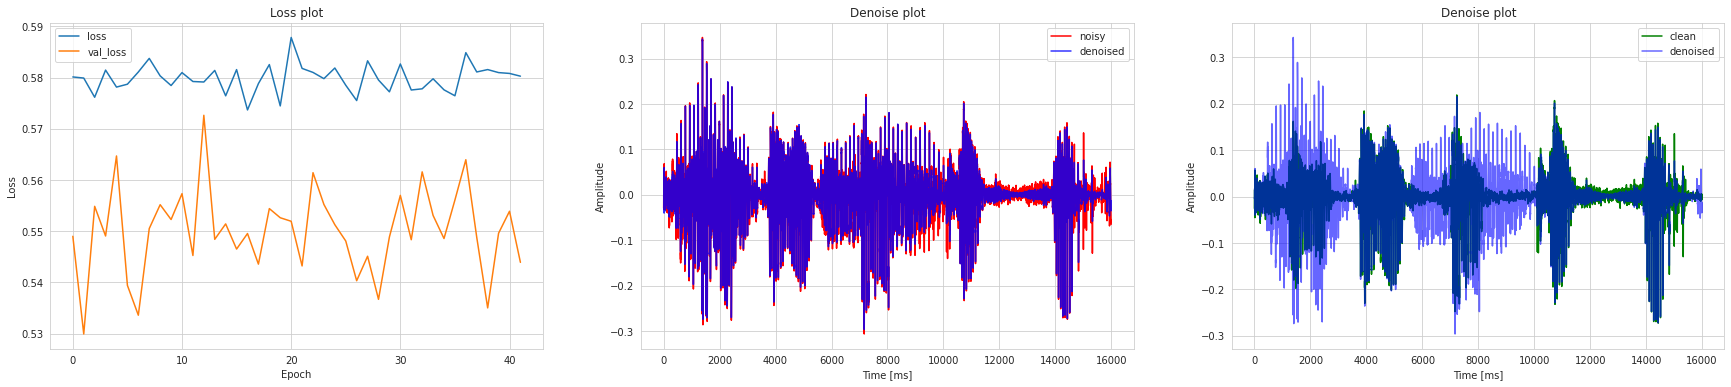

Epoch 43



Train Epoch:43	lr:0.00018	Loss:0.57969427	Time:1.33 m



Validation Loss:0.55240881


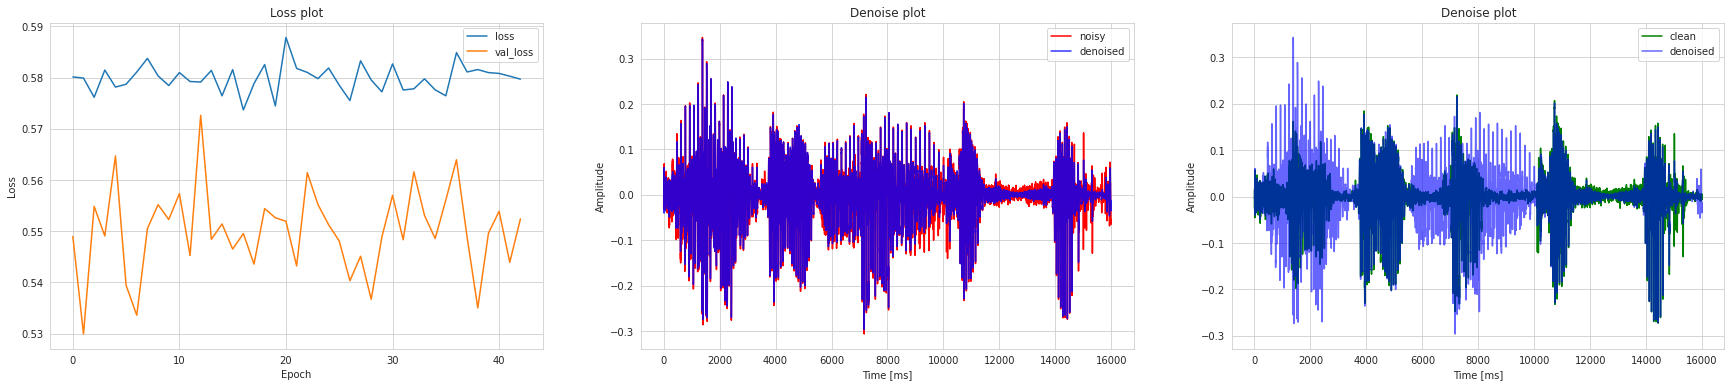

Epoch 44



Train Epoch:44	lr:0.00017	Loss:0.57897735	Time:1.31 m



Validation Loss:0.52861285


Epoch 45



Train Epoch:45	lr:0.00016	Loss:0.58655888	Time:1.33 m



Validation Loss:0.55356836


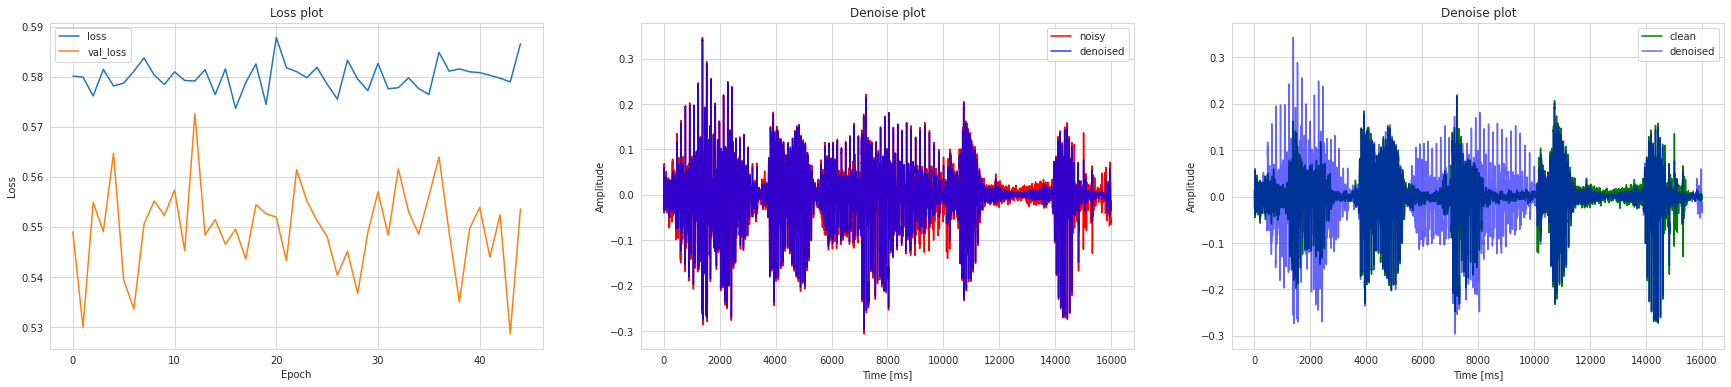

Epoch 46



Train Epoch:46	lr:0.00015	Loss:0.57884562	Time:1.34 m



Validation Loss:0.55495501


Epoch 47



Train Epoch:47	lr:0.00015	Loss:0.57798636	Time:1.33 m



Validation Loss:0.54062563
===> increase delta optimizer


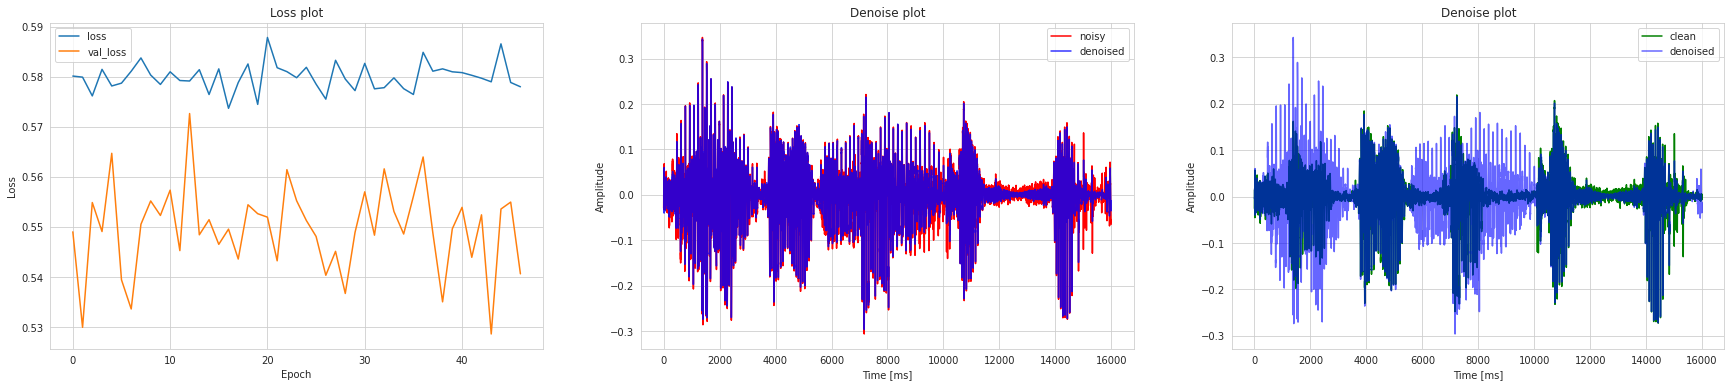

Epoch 48


KeyboardInterrupt: 

In [13]:
train_model(start_epoch = start_epoch, best = best,
            best_epoch = best_epoch, loaders = loaders,
            model = net, classifier = s.__S__, optimizer = optim,
            use_cuda = True, verbose = True, history = history, save = True, log_dir = '../log/fine_tuning/wavenet3/')